# Active Learning on MNIST

Analysis of locally performed active learning on mnist. Seeds `[20432, 10942, 83152, 59138, 49976, 10109]` were used.

For the active learning loop following parameters were used:

- Step size of 10 datapoints. (Number of datapoints transfered from unlabeled to labeled data pool)
- The pool of labeled datapoints was initialized with 20 randomly selected datapoints.
- The active learning loop was running 100 rounds. Ending with a total of 1020 selected and labeled datapoints.


Each experiment was characterized by a combination of seed, model and acquisition function.

Following models were examined:

- Mc Dropout
- Moment Propagation

For each experiment we used the described model types in association with each uncertainty sampling criterion to query new datapoints in the active learning environment.

Following uncertainty sampling strategies were used:

- Std. Mean
- Max. Entropy
- BALD
- Max. Var. Ratios

As a baseline Random selection of new datapoints was used.

In [43]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

In [45]:
BASE_PATH = os.path.join(os.getcwd(), "..", "..")
MODULES_PATH = os.path.join(BASE_PATH, "modules")
METRICS_PATH = os.path.join(BASE_PATH, "metrics")
STAT_PATH = os.path.join(BASE_PATH, "stats", "local")

In [46]:
sys.path.append(MODULES_PATH)
sys.path.append(os.path.join(BASE_PATH, "tf_al"))

In [47]:
%autoreload 2
from tf_al import ExperimentSuitMetrics
from utils import MetricsTransformer, Frame, ExperimentFrame, FrameScores, Stats, Table

In [48]:
dtypes = {
    "run": int,
    "iteration": int,
    "train_time": float,
    "eval_sparse_categorical_crossentropy": float,
    "eval_sparse_categorical_accuracy": float,
    "query_time": float,
    "labeled_pool_size": int,
    "unlabeled_pool_size": int,
    "method": str
}

In [49]:
#train_loss train_sparse_categorical_accuracy train_time query_time eval_sparse_categorical_crossentropy eval_sparse_categorical_accuracy eval_time indices_selected iteration labeled_pool_size unlabeled_pool_size

# Mc Dropout

In [50]:
base_experiment_path = os.path.join(METRICS_PATH, "mnist_local")
metrics_handler = ExperimentSuitMetrics(base_experiment_path)
df_mc = MetricsTransformer.load_from_dir(metrics_handler, "mc_dropout", dtype=dtypes)
scores = FrameScores(accuracy_column="eval_sparse_categorical_accuracy")
mc_frame = ExperimentFrame(df_mc, scores=scores)

/home/exleonem/.anaconda/envs/active_learning/lib/python3.8/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [51]:
df_mc = mc_frame.get_frame()

## Accuracy, Loss and labeling efficiency

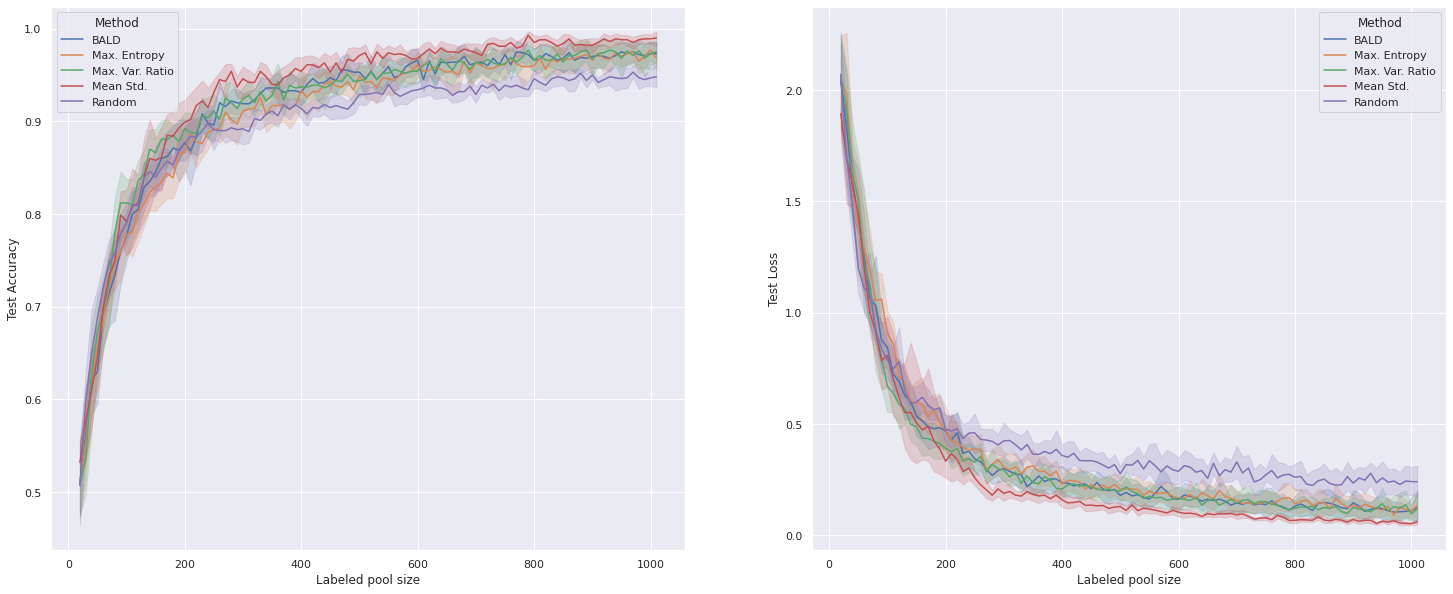

In [52]:
fig, ax = plt.subplots(1, 2, figsize=(25, 10))
sns.lineplot(ax=ax[0], data=df_mc, x="labeled_pool_size", y="eval_sparse_categorical_accuracy", hue="method")
ax[0].legend(title="Method")
ax[0].set_xlabel("Labeled pool size")
ax[0].set_ylabel("Test Accuracy")

sns.lineplot(ax=ax[1], data=df_mc, x="labeled_pool_size", y="eval_sparse_categorical_crossentropy", hue="method")
ax[1].legend(title="Method")
ax[1].set_xlabel("Labeled pool size")
ax[1].set_ylabel("Test Loss")

plt.savefig(os.path.join(STAT_PATH, "mc_dropout_loss_acc.png"))

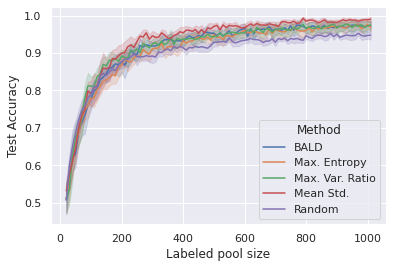

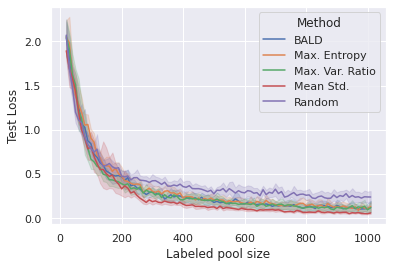

In [53]:
%autoreload 2
from utils import StatWriter
stat_writer = StatWriter(STAT_PATH)
stat_writer.write(df_mc)

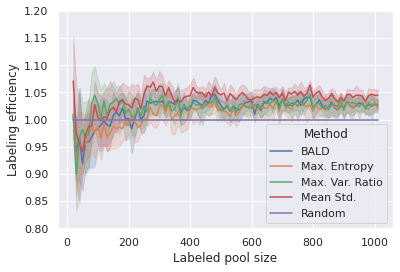

In [54]:
fig = sns.lineplot(data=df_mc, x="labeled_pool_size", y="mean_leff", hue="method")
fig.set(xlabel="Labeled pool size", ylabel="Labeling efficiency", ylim=(0.8, 1.20))
fig.legend(title="Method")
plt.savefig(os.path.join(STAT_PATH, "mc_dropout_leff.png"))

In [55]:
df_mc_mean = mc_frame.get_mean_frame()

/tmp/ipykernel_57844/3930386494.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mc_eff_df["query_time"] = mc_eff_df["query_time"]*1000


(0.4, 0.5387085299370323)

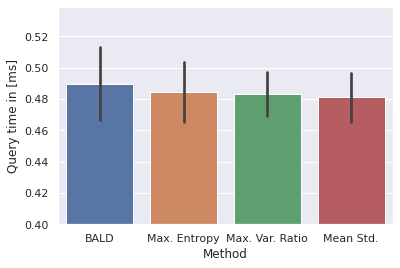

In [56]:
mc_eff_df = df_mc[["method", "model", "labeled_pool_size", "unlabeled_pool_size", "query_time", "mean_leff", "std_leff", "mean_qeff"]]
selector = mc_eff_df["method"] != "Random"
mc_eff_df["query_time"] = mc_eff_df["query_time"]*1000
ax = sns.barplot(data=mc_eff_df[selector], x="method", y="query_time", ci="sd")
ax.set(xlabel="Method", ylabel="Query time in [ms]")
ax.set_ylim(0.4)

# Moment Propagation

In [57]:
%autoreload 2
from utils import ExperimentFrame
df_mp = MetricsTransformer.load_from_dir(metrics_handler, "moment_propagation", dtype=dtypes)
scores = FrameScores(accuracy_column="eval_sparse_categorical_accuracy")
mp_frame = ExperimentFrame(df_mp, scores=scores)

/home/exleonem/.anaconda/envs/active_learning/lib/python3.8/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [58]:
df_mp = mp_frame.get_frame()

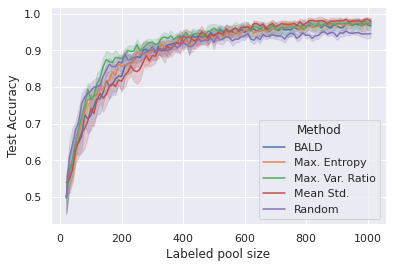

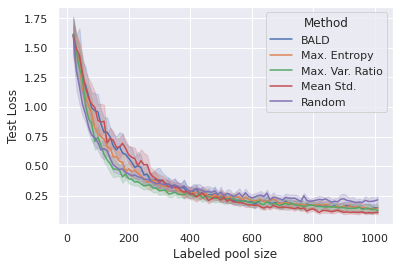

In [59]:
stat_writer.write(df_mp)

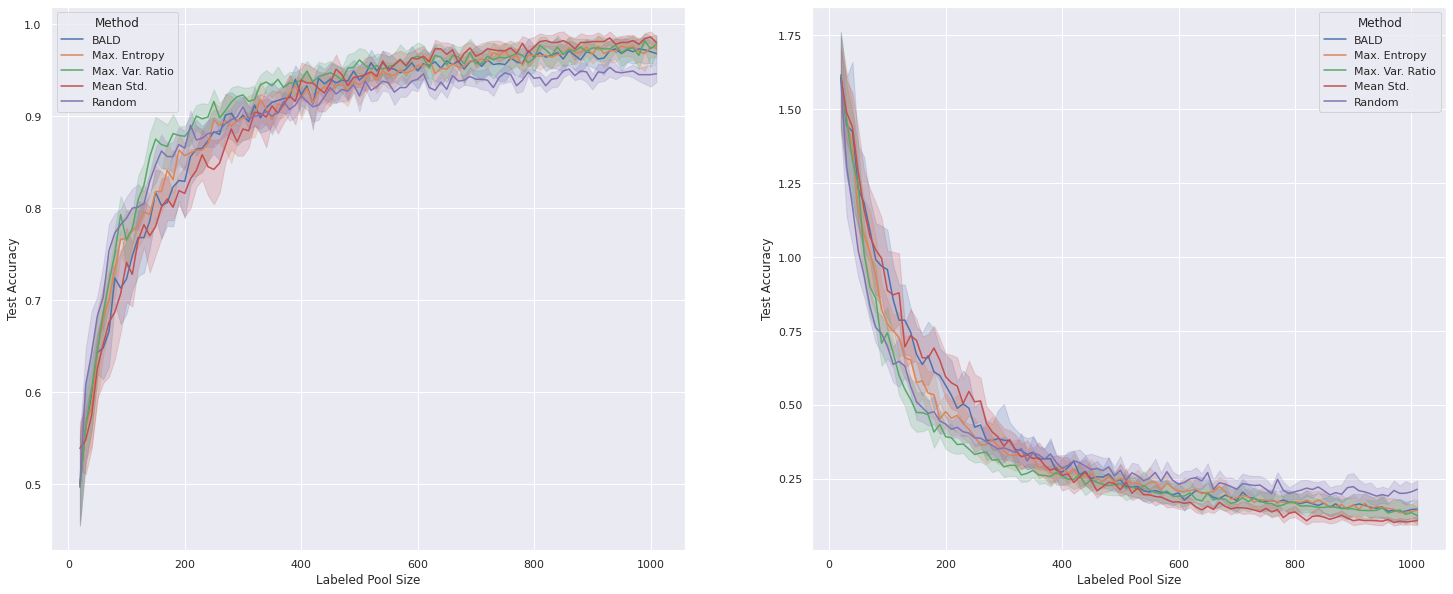

In [60]:
fig, ax = plt.subplots(1, 2, figsize=(25, 10))
selector = df_mp["eval_sparse_categorical_accuracy"] > .7
sns.lineplot(ax=ax[0], data=df_mp, x="labeled_pool_size", y="eval_sparse_categorical_accuracy", hue="method")
ax[0].set_xlabel("Labeled Pool Size")
ax[0].set_ylabel("Test Accuracy")
ax[0].legend(title="Method")

sns.lineplot(ax=ax[1], data=df_mp, x="labeled_pool_size", y="eval_sparse_categorical_crossentropy", hue="method")
ax[1].set_xlabel("Labeled Pool Size")
ax[1].set_ylabel("Test Accuracy")
ax[1].legend(title="Method")

plt.savefig(os.path.join(STAT_PATH, "mp_mnist_loss_acc.png"))

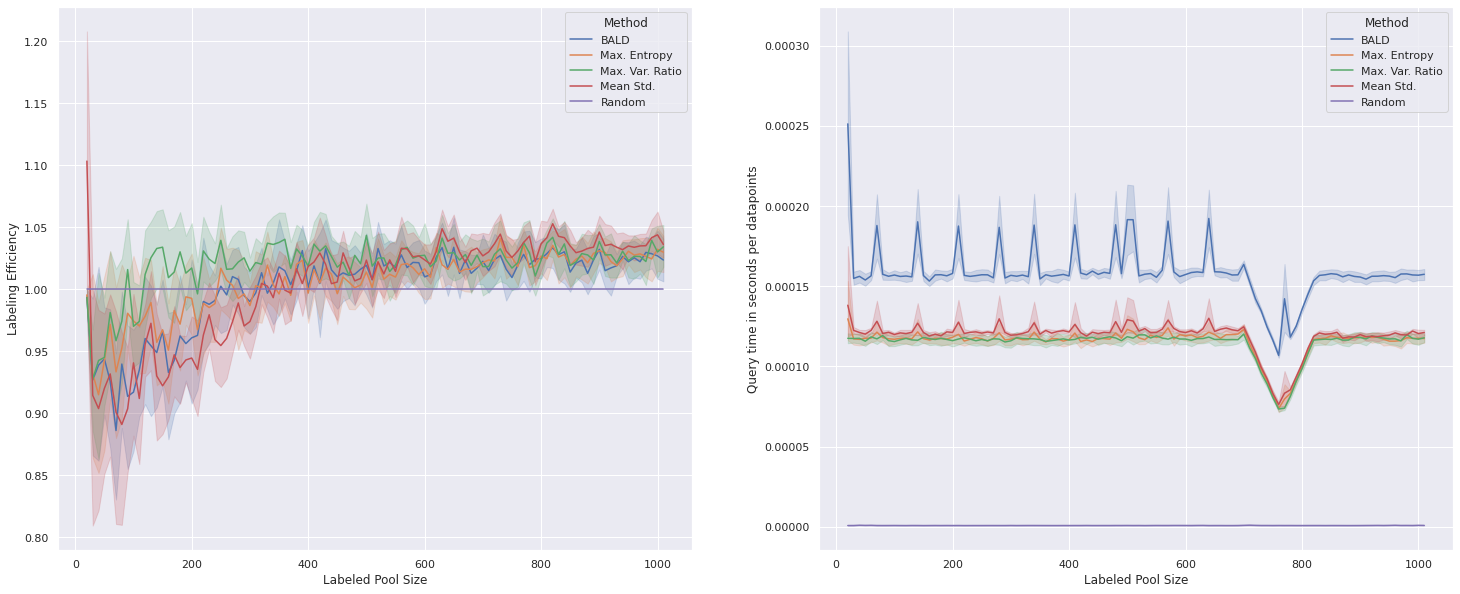

In [61]:
fig, ax = plt.subplots(1, 2, figsize=(25, 10))
sns.lineplot(ax=ax[0], data=df_mp, x="labeled_pool_size", y="mean_leff", hue="method")
ax[0].set_xlabel("Labeled Pool Size")
ax[0].set_ylabel("Labeling Efficiency")
ax[0].legend(title="Method")

sns.lineplot(ax=ax[1], data=df_mp, x="labeled_pool_size", y="query_time", hue="method")
ax[1].set_xlabel("Labeled Pool Size")
ax[1].set_ylabel("Query time in seconds per datapoints")
ax[1].legend(title="Method")

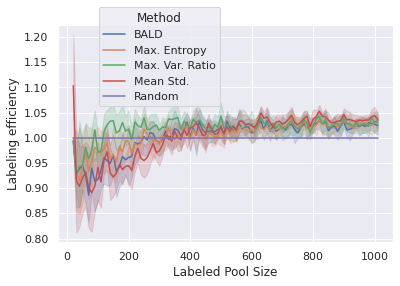

In [62]:
fig = sns.lineplot(data=df_mp, x="labeled_pool_size", y="mean_leff", hue="method")
fig.set(xlabel="Labeled Pool Size", ylabel="Labeling efficiency")
fig.legend(title="Method", loc="lower right", bbox_to_anchor=(0.5, 0.6))
plt.savefig(os.path.join(STAT_PATH, "moment_propagation_leff.png"))

# Comparison of Models

In [63]:
%autoreload 
num_of_datapoints = np.array([10_000, 20_000, 40_000, 80_000, 160_000])
qt_dp_mp = Stats.query_time_per_datapoints(df_mp, num_of_datapoints)
qt_dp_mc = Stats.query_time_per_datapoints(df_mc, num_of_datapoints)

In [64]:
qt_dp_mc.insert(0, "model", "Mc Dropout")
qt_dp_mp.insert(0, "model", "Moment Propagation")

In [65]:
merged_times = pd.concat([qt_dp_mc, qt_dp_mp])
merged_times = merged_times.rename(columns={"model": "Model", "method": "Method"})

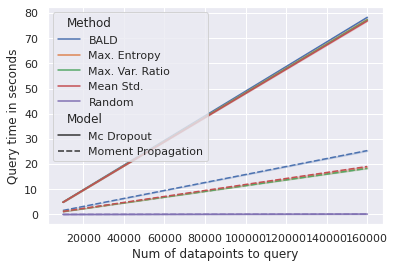

In [66]:
fig = sns.lineplot(data=merged_times, x="size", y="times", hue="Method", style="Model")
fig.set(xlabel="Num of datapoints to query", ylabel="Query time in seconds")

plt.savefig(os.path.join(STAT_PATH, "runtime_accumulated.png"))

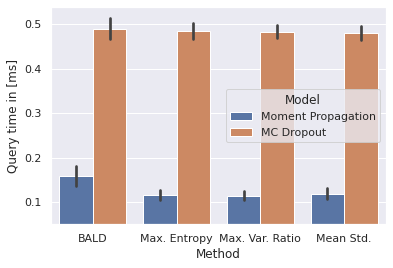

In [67]:
composite_df = pd.concat([df_mp, df_mc])
composite_df["query_time"] = composite_df["query_time"]*1000

selector = composite_df["method"] != "Random"
fig = sns.barplot(data=composite_df[selector], x="method", y="query_time", hue="model", ci="sd")
fig.set(xlabel="Method", ylabel="Query time in [ms]")
fig.legend(title="Model")
fig.set_ylim(0.05)
plt.savefig(os.path.join(STAT_PATH, "mp_mc_method_runtime_comp.png"))

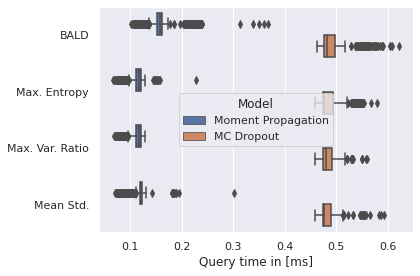

In [68]:
composite_df = pd.concat([df_mp, df_mc])
#composite_df = composite_df.groupby(["model", "method", "run"]).mean()
composite_df["query_time"] = composite_df["query_time"]*1000
selector = composite_df["method"] != "Random"

#plt.figure(dpi=300)

fig = sns.boxplot(data=composite_df[selector], y="method", x="query_time", hue="model")
fig.set(xlabel="Query time in [ms]", ylabel="")
fig.legend(title="Model")

#plt.grid()
plt.tight_layout()
plt.savefig(os.path.join(STAT_PATH, "mp_mc_runtime_boxplot.png"))

In [69]:
df_mp_mean = mp_frame.get_mean_frame()
df_mc_mean = mc_frame.get_mean_frame()

df_mc_mean["query_time"] = df_mc_mean["query_time"]-df_mp_mean["query_time"]
df_mc_mean["query_time"] = df_mc_mean["query_time"]*1000

(0.25, 0.4)

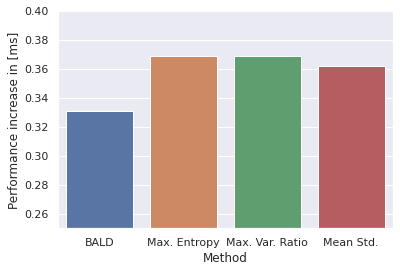

In [70]:
selector = df_mc_mean["method"] != "Random"
fig = sns.barplot(data=df_mc_mean[selector], x="method", y="query_time", ci=None)
fig.set(xlabel="Method", ylabel="Performance increase in [ms]")
fig.set_ylim(0.25, 0.4)

In [71]:
# Compare acquisition functions
df_merged = pd.concat([df_mc, df_mp])

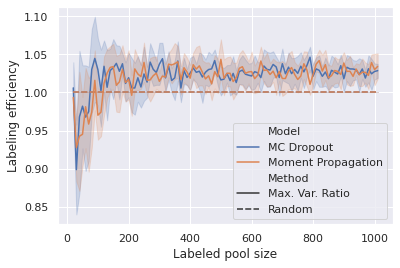

In [72]:
random_sel = df_merged["method"] == "Random"
selector = np.logical_or(df_merged["method"] == "Max. Var. Ratio", random_sel)
fig = sns.lineplot(data=df_merged[selector], x="labeled_pool_size", y="mean_leff", style="method", hue="model")
handles, labels = fig.get_legend_handles_labels()
labels[0] = labels[0].capitalize()
labels[-3] = labels[-3].capitalize()
fig.set(xlabel="Labeled pool size", ylabel="Labeling efficiency")
fig.legend(handles, labels)
plt.savefig(os.path.join(STAT_PATH, "comp_leff_max_ratios.png"))

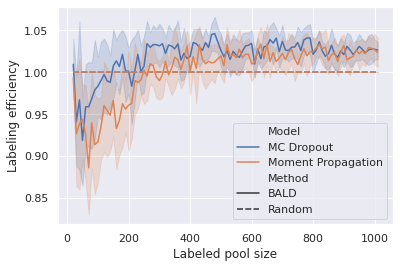

In [73]:
random_sel = df_merged["method"] == "Random"
selector = np.logical_or(df_merged["method"] == "BALD", random_sel)
fig = sns.lineplot(data=df_merged[selector], x="labeled_pool_size", y="mean_leff", style="method", hue="model")
handles, labels = fig.get_legend_handles_labels()
labels[0] = labels[0].capitalize()
labels[-3] = labels[-3].capitalize()
fig.set(xlabel="Labeled pool size", ylabel="Labeling efficiency")
fig.legend(handles, labels)
plt.savefig(os.path.join(STAT_PATH, "comp_leff_bald.png"))

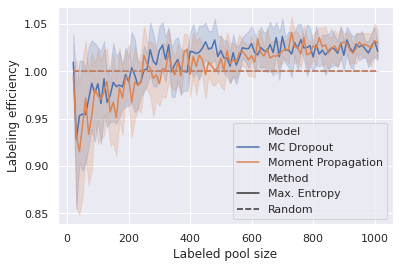

In [74]:
random_sel = df_merged["method"] == "Random"
selector = np.logical_or(df_merged["method"] == "Max. Entropy", random_sel)
fig = sns.lineplot(data=df_merged[selector], x="labeled_pool_size", y="mean_leff", style="method", hue="model")
handles, labels = fig.get_legend_handles_labels()
labels[0] = labels[0].capitalize()
labels[-3] = labels[-3].capitalize()
fig.set(xlabel="Labeled pool size", ylabel="Labeling efficiency")
fig.legend(handles, labels)
plt.savefig(os.path.join(STAT_PATH, "comp_leff_max_entropy.png"))

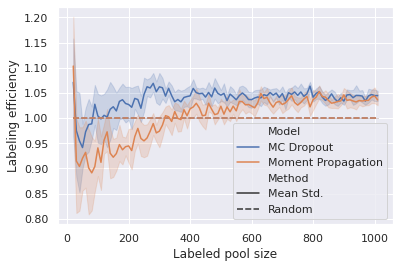

In [75]:
random_sel = df_merged["method"] == "Random"
selector = np.logical_or(df_merged["method"] == "Mean Std.", random_sel)
fig = sns.lineplot(data=df_merged[selector], x="labeled_pool_size", y="mean_leff", style="method", hue="model")
handles, labels = fig.get_legend_handles_labels()
labels[0] = labels[0].capitalize()
labels[-3] = labels[-3].capitalize()
fig.set(xlabel="Labeled pool size", ylabel="Labeling efficiency")
fig.legend(handles, labels)
plt.savefig(os.path.join(STAT_PATH, "comp_leff_mean_std.png"))

Text(0.5, 1.0, 'Acquisition function: Max. Var. Ratio')

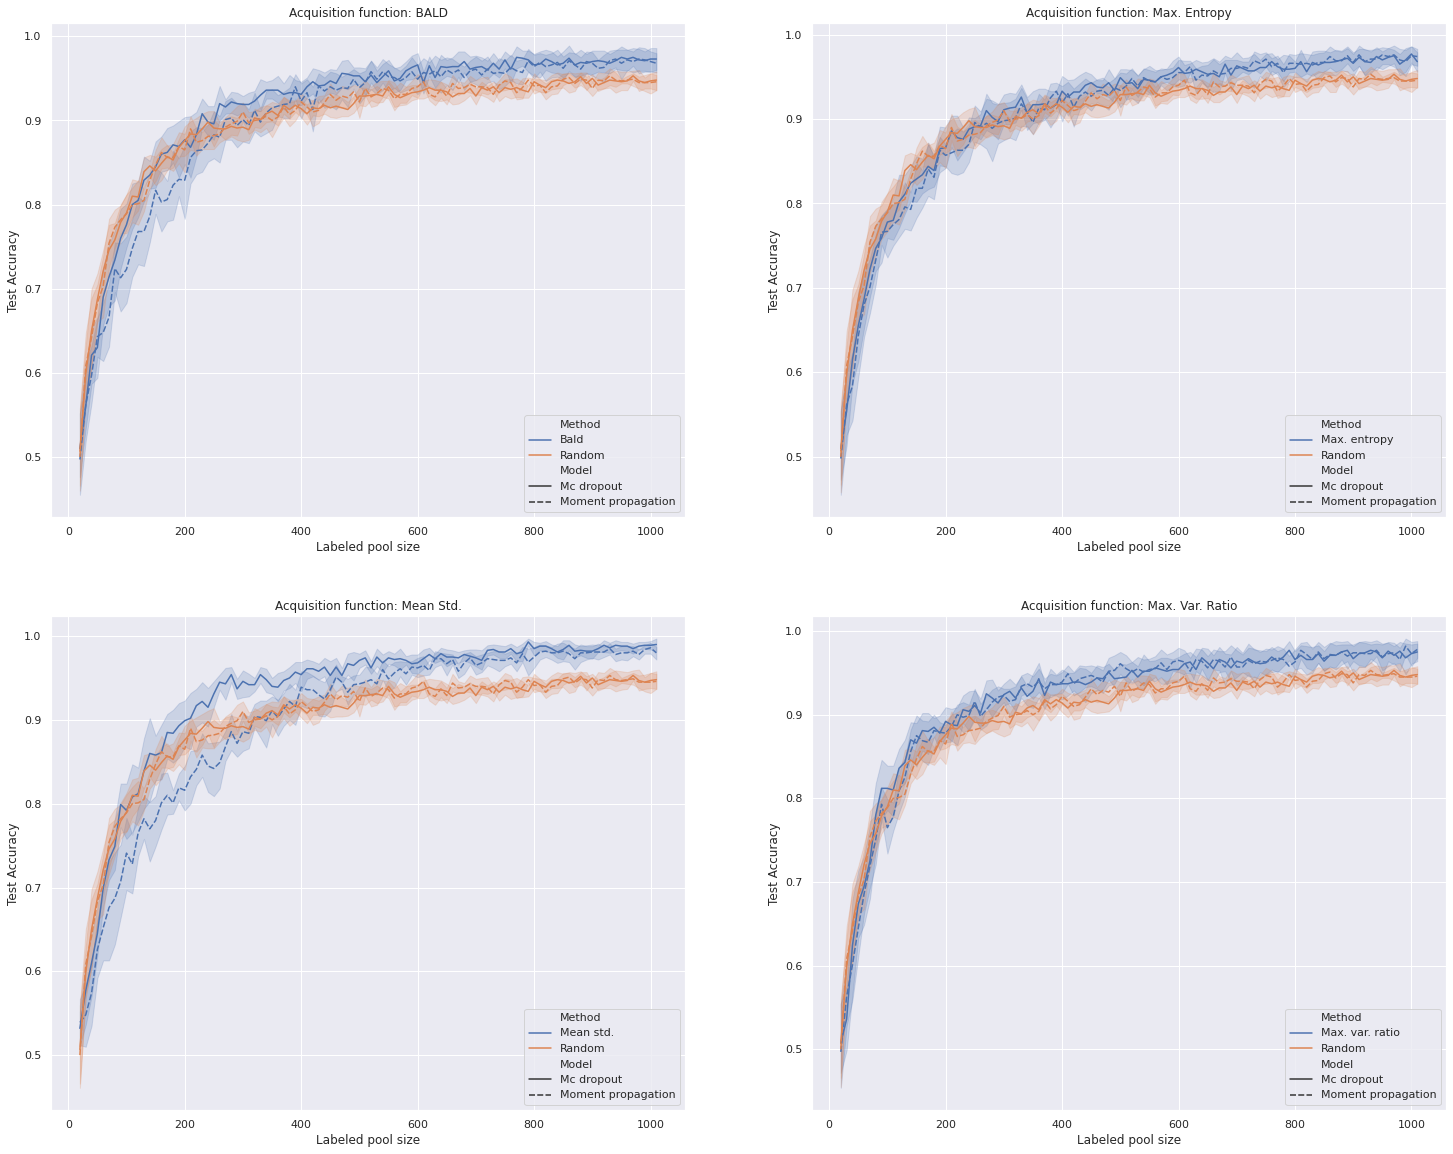

In [76]:
fig, ax = plt.subplots(2, 2, figsize=(25, 20))
random_sel = df_merged["method"] == "Random"

selector = np.logical_or(df_merged["method"] == "BALD", random_sel)
sns.lineplot(ax=ax[0][0], data=df_merged[selector], x="labeled_pool_size", y="eval_sparse_categorical_accuracy", hue="method", style="model")
ax[0][0].set_xlabel("Labeled pool size")
ax[0][0].set_ylabel("Test Accuracy")
handles, labels = ax[0][0].get_legend_handles_labels()
ax[0][0].legend(handles, list(map(lambda x: x.capitalize(), labels)))
ax[0][0].set_title("Acquisition function: BALD")

selector = np.logical_or(df_merged["method"] == "Max. Entropy", random_sel)
fig = sns.lineplot(ax=ax[0][1], data=df_merged[selector], x="labeled_pool_size", y="eval_sparse_categorical_accuracy", hue="method", style="model")
ax[0][1].set_xlabel("Labeled pool size")
ax[0][1].set_ylabel("Test Accuracy")
handles, labels = ax[0][1].get_legend_handles_labels()
ax[0][1].legend(handles, list(map(lambda x: x.capitalize(), labels)))
ax[0][1].set_title("Acquisition function: Max. Entropy")

selector = np.logical_or(df_merged["method"] == "Mean Std.", random_sel)
fig = sns.lineplot(ax=ax[1][0], data=df_merged[selector], x="labeled_pool_size", y="eval_sparse_categorical_accuracy", hue="method", style="model")
ax[1][0].set_xlabel("Labeled pool size")
ax[1][0].set_ylabel("Test Accuracy")
handles, labels = ax[1][0].get_legend_handles_labels()
ax[1][0].legend(handles, list(map(lambda x: x.capitalize(), labels)))
ax[1][0].set_title("Acquisition function: Mean Std.")

selector = np.logical_or(df_merged["method"] == "Max. Var. Ratio", random_sel)
fig = sns.lineplot(ax=ax[1][1], data=df_merged[selector], x="labeled_pool_size", y="eval_sparse_categorical_accuracy", hue="method", style="model")
ax[1][1].set_xlabel("Labeled pool size")
ax[1][1].set_ylabel("Test Accuracy")
handles, labels = ax[1][1].get_legend_handles_labels()
ax[1][1].legend(handles, list(map(lambda x: x.capitalize(), labels)))
ax[1][1].set_title("Acquisition function: Max. Var. Ratio")

In [77]:
stat_writer.write_compare(df_merged)

In [78]:
auc_mean_std = Table.auc(pd.concat([df_mc, df_mp]), decimals=3)
auc_mean_std = Frame.merge_mean_std(auc_mean_std)
auc_mean_std.columns = ["AUC"]
auc_mean_std

AUC
Method          Model                            
BALD            MC Dropout          0.898 ± 0.016
                Moment Propagation   0.885 ± 0.02
Max. Entropy    MC Dropout          0.892 ± 0.017
                Moment Propagation  0.888 ± 0.016
Max. Var. Ratio MC Dropout          0.902 ± 0.017
                Moment Propagation    0.9 ± 0.017
Mean Std.       MC Dropout          0.915 ± 0.012
                Moment Propagation  0.886 ± 0.013
Random          MC Dropout          0.881 ± 0.008
                Moment Propagation  0.882 ± 0.009

In [79]:
table_query_time = Table.query_time(pd.concat([df_mc, df_mp]), decimals=6)
table_query_time["Mean"] = table_query_time["Mean"]*1000
table_query_time["Std"] = table_query_time["Std"]*1000
table_query_time

Mean    Std
Method          Model                           
BALD            MC Dropout          0.490  0.023
                Moment Propagation  0.159  0.023
Max. Entropy    MC Dropout          0.484  0.019
                Moment Propagation  0.115  0.011
Max. Var. Ratio MC Dropout          0.483  0.014
                Moment Propagation  0.114  0.010
Mean Std.       MC Dropout          0.481  0.016
                Moment Propagation  0.119  0.013
Random          MC Dropout          0.001  0.000
                Moment Propagation  0.001  0.000

In [80]:
table_query_time = Frame.merge_mean_std(table_query_time, decimals=3)
table_query_time.columns = ["Query Time"]
table_query_time

Query Time
Method          Model                            
BALD            MC Dropout           0.49 ± 0.023
                Moment Propagation  0.159 ± 0.023
Max. Entropy    MC Dropout          0.484 ± 0.019
                Moment Propagation  0.115 ± 0.011
Max. Var. Ratio MC Dropout          0.483 ± 0.014
                Moment Propagation   0.114 ± 0.01
Mean Std.       MC Dropout          0.481 ± 0.016
                Moment Propagation  0.119 ± 0.013
Random          MC Dropout            0.001 ± 0.0
                Moment Propagation    0.001 ± 0.0

In [81]:
qt_auc = pd.concat([auc_mean_std, table_query_time], axis=1)
qt_auc.to_latex(os.path.join(STAT_PATH, "tables", "auc_qt_mp_mc.tex"))
qt_auc

AUC     Query Time
Method          Model                                           
BALD            MC Dropout          0.898 ± 0.016   0.49 ± 0.023
                Moment Propagation   0.885 ± 0.02  0.159 ± 0.023
Max. Entropy    MC Dropout          0.892 ± 0.017  0.484 ± 0.019
                Moment Propagation  0.888 ± 0.016  0.115 ± 0.011
Max. Var. Ratio MC Dropout          0.902 ± 0.017  0.483 ± 0.014
                Moment Propagation    0.9 ± 0.017   0.114 ± 0.01
Mean Std.       MC Dropout          0.915 ± 0.012  0.481 ± 0.016
                Moment Propagation  0.886 ± 0.013  0.119 ± 0.013
Random          MC Dropout          0.881 ± 0.008    0.001 ± 0.0
                Moment Propagation  0.882 ± 0.009    0.001 ± 0.0

# Varianz erste Iteration

(0.44, 0.575)

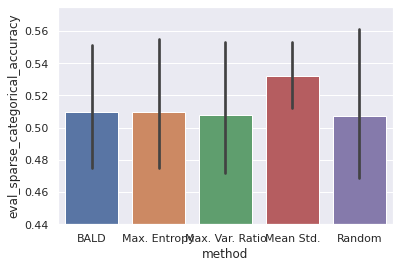

In [82]:
selector = df_mc["iteration"] == 1
fig = sns.barplot(data=df_mc[selector], x="method", y="eval_sparse_categorical_accuracy")
fig.set_ylim(0.44, 0.575)

(0.425, 0.575)

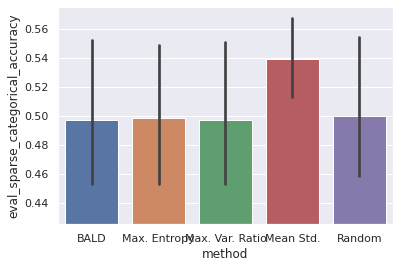

In [83]:
selector = df_mp["iteration"] == 1
fig = sns.barplot(data=df_mp[selector], x="method", y="eval_sparse_categorical_accuracy")
fig.set_ylim(0.425, 0.575)